In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from metrics import sharpe, max_drawdown
from strategy import run_backtest_onpercent, run_put_strategy
from plots import plot_with_hodl, plot_rebalances, plot_all
from loader import get_gas_price_per_block, get_swap_data_per_block

In [2]:
range_percentages = [10*i for i in range(1,4)]
move_percentages = [5*i for i in range(1,10,2)]
durations = [f'{i} day' for i in [3,7,14]]
gas_price = get_gas_price_per_block(eth_path='../data/eth_price.csv', gas_path='../data/gas_price.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
swap_path = '../data/eth_price.csv'
POOL_NAME = 'WETH-USDC'
swap_data = get_swap_data_per_block(swap_path)

def otm_range(price_df, params):
    range_percent = params['range_percent']
    is_complete = params['is_complete']
    # the upper ba
    upper_tick = (price_df.price*(1 + range_percent/100)).dropna()
    if is_complete:
        lower_tick = price_df.price*(1.0001)
    else:
        lower_tick = upper_tick/1.0001
    return lower_tick, upper_tick

def itm_range(price_df, params):
    range_percent = params['range_percent']
    is_complete = params['is_complete']
    lower_tick = (price_df.price*(1 - range_percent/100)).dropna()
    if is_complete:
        upper_tick= price_df.price/(1.0001)
    else:
        upper_tick = lower_tick*1.0001
    return lower_tick, upper_tick

In [5]:
swap_path = '../data/eth_price.csv'
POOL_NAME = 'WETH-USDC'
swap_data = get_swap_data_per_block(swap_path)
out = Parallel(n_jobs=18, verbose=True)(delayed(run_put_strategy)
                (amount_invested = 1e6,swap_path=swap_path, gas_price=gas_price,disable_costs=False,
                decimal_diff=12, swap_cost=13e-3, duration=duration,  get_range=otm_range, params={'range_percent':range_percentage, 'is_complete':True})
                for range_percentage, duration in itertools.product(range_percentages, durations))

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   4 out of   9 | elapsed:   48.6s remaining:  1.0min
[Parallel(n_jobs=18)]: Done   9 out of   9 | elapsed:   49.1s finished


In [6]:
def rets(out):
    returns  = 100*(out.iloc[-1]-out.iloc[0])/out.iloc[0]
    return round(returns,2)

def max_drawdown(out):
    rets = out.pct_change().dropna()
    cum_rets = (1+rets).cumprod()
    max_rets = (1+rets).cumprod().cummax()
    draw_downs = 100*(max_rets-cum_rets)/max_rets
    return round(max(draw_downs), 2)

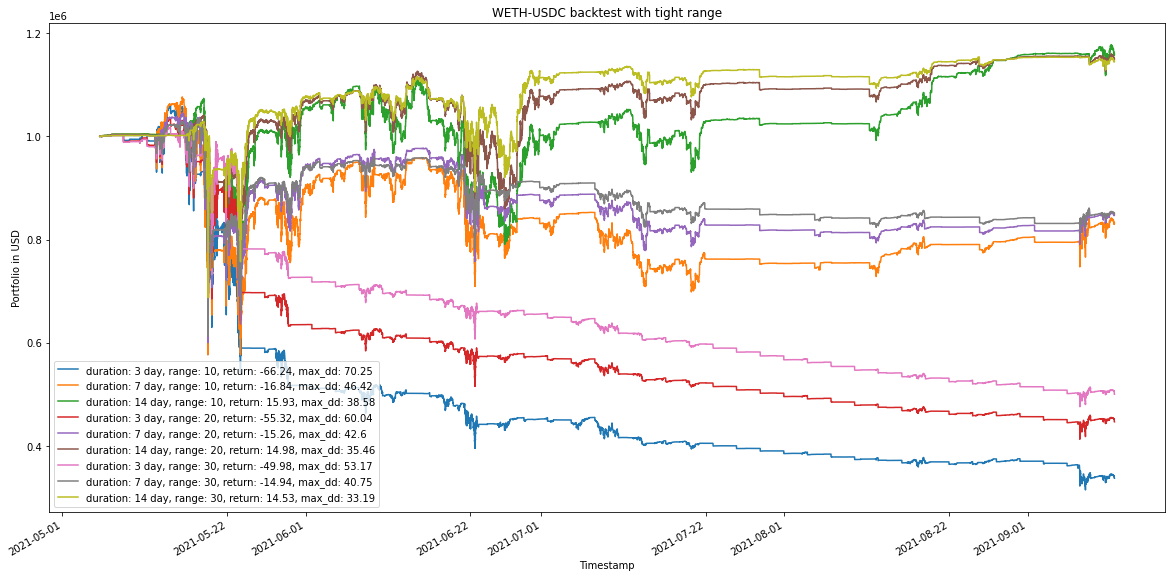

In [7]:
pool_name = POOL_NAME
for i in range(len(out)):
    out[i]['holdings']['usd_with_fees'].plot(figsize=(20, 10))
L = plt.legend(loc='lower left')
count = 0
for i in range(len(out)):
    L.get_texts()[count].set_text(f'duration: {out[i]["duration"]}, range: {out[i]["range_percent"]}, return: {rets(out[i]["holdings"]["usd_with_fees"])}, max_dd: {max_drawdown(out[i]["holdings"]["usd_with_fees"])}')
    count+=1
plt.title(f'{pool_name} backtest with tight range')
plt.xlabel('Timestamp')
plt.ylabel('Portfolio in USD')
plt.show()